In [44]:
import pandas as pd
import numpy as np

DECOMPILERS=['CFR','Fernflower','Jadx','Procyon']

# Read main DF
raw_main_df = pd.read_parquet('main_decompilation_df.parquet')

# Read DF with matching errors
match_fail_df = pd.read_parquet('match_fail_df.parquet')
# Remove duplicates
match_fail_df = match_fail_df[~match_fail_df[['Dataset','Name']].duplicated()]

#Correct main DF
merged = raw_main_df.merge(match_fail_df, on=['Dataset','Name'])
for d in DECOMPILERS:
    nonnull_mask = ~merged[d+'_no_match'].isna()
    raw_main_df[d+'_F'] = raw_main_df[d+'_F'].mask(nonnull_mask, other=(raw_main_df[d+'_F'] + merged[d+'_no_match'] - merged[d+'_extra']))
    # Do something about a handful of cases where apkanalyzer reports too few methods
    raw_main_df[d+'_F'] = raw_main_df[d+'_F'].mask(nonnull_mask, other=(raw_main_df[d+'_F'].where(raw_main_df[d+'_F'] <= raw_main_df['Methods'], other=raw_main_df['Methods'])))

# Dataframe without NULL elements
main_df = raw_main_df[~raw_main_df.CFR_T.isnull()]
# We don't want 'object' datatype if it can be avoided...
main_df = main_df.astype({d+'_F':np.int64 for d in DECOMPILERS})
main_df = main_df.astype({d+'_T':bool for d in DECOMPILERS})

In [47]:
# Base stats about datasets
base_stats = pd.DataFrame()
base_stats['Processed'] = raw_main_df.groupby('Dataset')['Name'].count()
base_stats['Packed (APKiD)'] = raw_main_df[raw_main_df.Packed].groupby('Dataset')['Name'].count()
print(base_stats.to_latex())
    

\begin{tabular}{lrr}
\toprule
{} &  Processed &  Packed (APKiD) \\
\midrule
f-droid &       3018 &               0 \\
google  &      13594 &             127 \\
malware &      23333 &             131 \\
\bottomrule
\end{tabular}



In [49]:
# Timeouts
print(raw_main_df.groupby('Dataset')[[d+'_T' for d in DECOMPILERS]].sum(numeric_only=False).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  CFR\_T &  Fernflower\_T &  Jadx\_T &  Procyon\_T \\
Dataset &        &               &         &            \\
\midrule
f-droid &      1 &           164 &       0 &         37 \\
google  &     21 &          7652 &       4 &       1419 \\
malware &      8 &          1955 &       1 &        130 \\
\bottomrule
\end{tabular}



In [8]:
# Superflous and missed matches due to method limitations
failed = raw_main_df.groupby('Dataset')[[d+'_F' for d in DECOMPILERS]].sum()
failed.columns = DECOMPILERS
superflous = match_fail_df.groupby('Dataset')[[d+'_extra' for d in DECOMPILERS]].sum()
superflous.columns = DECOMPILERS
unmatched = match_fail_df.groupby('Dataset')[[d+'_no_match' for d in DECOMPILERS]].sum()
unmatched.columns = DECOMPILERS

pd.set_option("display.precision", 3)  
print((superflous.div(failed)*100).to_latex())
print((unmatched.div(failed)*100).to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  CFR &  Fernflower &  Jadx &  Procyon \\
Dataset &      &             &       &          \\
\midrule
f-droid &  0.0 &      29.255 &   0.0 &   24.874 \\
google  &  0.0 &       0.359 &   0.0 &    0.311 \\
malware &  0.0 &      12.274 &   0.0 &   14.705 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &    CFR &  Fernflower &    Jadx &  Procyon \\
Dataset &        &             &         &          \\
\midrule
f-droid &  4.378 &       0.140 &  13.551 &    8.685 \\
google  &  0.492 &       0.009 &  34.030 &    0.179 \\
malware &  1.229 &       0.026 &   2.649 &    1.109 \\
\bottomrule
\end{tabular}



In [48]:
# Successfully decompiled apps using jadx vs an ensemble
decomp_stats = pd.DataFrame()
temp_df = raw_main_df.copy()

for d in DECOMPILERS:
    temp_df[d+'_FT'] = temp_df[d+'_F'].isnull() | (temp_df[d+'_F'] > 0) | temp_df[d+'_T']

pd.set_option("display.precision", 2)    
decomp_stats['Jadx'] = temp_df[~temp_df['Jadx_FT']].groupby('Dataset')['Name'].count().div(base_stats['Processed'], axis=0)*100
decomp_stats['Ensemble'] = temp_df[~(temp_df[[d+'_FT' for d in DECOMPILERS]].all(axis=1))].groupby('Dataset')['Name'].count().div(base_stats['Processed'], axis=0)*100
decomp_stats['All decompilers'] = temp_df[~(temp_df[[d+'_FT' for d in DECOMPILERS]].any(axis=1))].groupby('Dataset')['Name'].count().div(base_stats['Processed'], axis=0)*100

print(decomp_stats.to_latex())


\begin{tabular}{lrrr}
\toprule
{} &   Jadx &  Ensemble &  All decompilers \\
\midrule
f-droid &  74.52 &     74.69 &             8.65 \\
google  &  21.02 &     21.03 &             0.15 \\
malware &  78.81 &     79.68 &             0.60 \\
\bottomrule
\end{tabular}



In [113]:
# Decompiler co-failure distribution
decomp_df = pd.read_parquet('decomp_fail_dist_df.parquet')
decomp_df_rel = decomp_df.loc[:,'>0':]
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
print((decomp_df_rel.div(decomp_df.Total, axis=0)*100).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      >0 &      >1 &    All \\
\midrule
CFR        & 40.9549 & 11.6763 & 0.0378 \\
Fernflower &  8.8871 &  0.4419 & 0.0014 \\
Jadx       & 71.9225 & 21.9917 & 4.3338 \\
Procyon    & 41.5437 &  2.2230 & 0.0073 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrr}
\toprule
{} &   CFR &  Fernflower &      Jadx &  Procyon \\
Dataset       &       &             &           &          \\
\midrule
f-droid       &  0.69 &        0.56 &  4.81e-03 &     0.29 \\
google        &  0.84 &        1.05 &  1.15e-02 &     0.32 \\
malware       &  1.75 &        1.46 &  4.72e-02 &     1.08 \\
weighted avg. &  1.09 &        1.02 &  2.12e-02 &     0.56 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &   CFR &  Fernflower &      Jadx &  Procyon \\
Dataset       &       &             &           &          \\
\midrule
f-droid       &  0.74 &        5.97 &  5.16e-03 &     1.52 \\
google        &  1.03 &       58.42 &  1.89e-02 &    11.01 \\
malware       &  1.84 &        9.73 &  4.43e-02 &     1.67 \\
weighted avg. &  1.20 &       24.70 &  2.28e-02 &     4.73 \\
\bottomrule
\end{tabular}



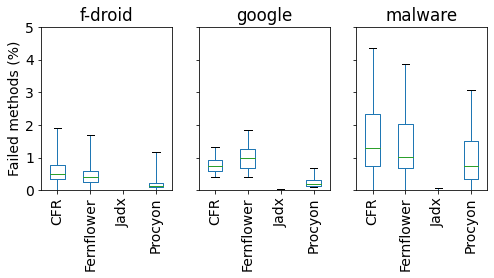

In [50]:
# Failure rates of decompilers

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42

fail_rates = main_df[[d+'_F' for d in DECOMPILERS]].div(main_df['Methods'], axis=0)
fail_rates.columns = DECOMPILERS
timeout_mask = main_df[[d+'_T' for d in DECOMPILERS]]
timeout_mask.columns = DECOMPILERS
fail_rates_w_timeouts = fail_rates.mask(timeout_mask, other=1.0)


plt.rc('font', size=14) 
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
fig.set_size_inches(8,3)
for idx,d in enumerate(main_df['Dataset'].unique()):
    ax = (fail_rates[~(timeout_mask.any(axis=1)) & (main_df['Dataset'] == d)]*100).plot.box(ax=axes[idx], showfliers=False, whis=[5,95])
    if idx == 0:
        ax.set_ylabel('Failed methods (%)')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(d)
    ax.set_ylim(0,5)
    axes[idx] = ax

    
fig.savefig("latex/figures/failrates.pdf", bbox_inches='tight')

fail_rate_means = fail_rates.join(main_df['Dataset'])[(~timeout_mask.any(axis=1))].groupby('Dataset').mean()
fail_rate_means.index = fail_rate_means.index.astype(str)
weighted_average = fail_rate_means.mean()
weighted_average.name = 'weighted avg.'
print((fail_rate_means.append(weighted_average)*100).to_latex())

# Same table as above, but with timeouts included
fail_rate_means_timeouts = fail_rates_w_timeouts.join(main_df['Dataset']).groupby('Dataset').mean()
fail_rate_means_timeouts.index = fail_rate_means_timeouts.index.astype(str)
weighted_average_timeouts = fail_rate_means_timeouts.mean()
weighted_average_timeouts.name = 'weighted avg.'
print((fail_rate_means_timeouts.append(weighted_average_timeouts)*100).to_latex())

pd.reset_option('display.float_format')

In [51]:
# Jadx fail rate on different datasets
import numpy as np
jadx_rate_df = raw_main_df[~raw_main_df.Jadx_T].copy()
jadx_rate_df['JadxRate'] = raw_main_df.Jadx_F/raw_main_df.Methods

Dataset
f-droid             5.16e-03
google              1.14e-02
malware             4.42e-02
mlwr. fam. means    2.89e-02
Name: JadxRate, dtype: float64

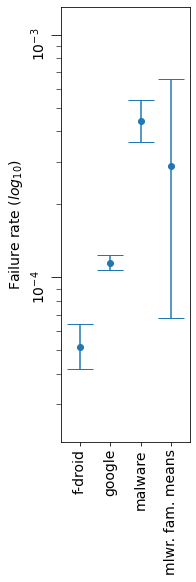

In [53]:
# Plot jadx fail rate with estimated confidence intervals

# Add malware family means as a new 'dataset'
family_means = pd.DataFrame(columns=jadx_rate_df.columns)
family_means['JadxRate'] = jadx_rate_df[jadx_rate_df.Dataset == 'malware'].groupby('Family')['JadxRate'].mean()
family_means.Family = family_means.index
family_means['Dataset'] = 'mlwr. fam. means'
jadx_rate_df = jadx_rate_df.append(family_means, ignore_index=True)

# Bootstrap sampling
samplings = [jadx_rate_df.sample(frac=1.0, replace=True).groupby('Dataset')['JadxRate'].mean() for i in range(1000)]

means = jadx_rate_df.groupby('Dataset')['JadxRate'].mean()
errors = np.abs(pd.DataFrame(samplings).quantile([0.025, 0.975]).to_numpy() - means.to_numpy())
ax = means.plot(yerr=errors, capsize=13, figsize=(2.3, 8), fmt='o')
ax.set_yscale('log')
ax.set_ylabel('Failure rate ($log_{10}$)')
ax.set_xlabel(None)
ax.tick_params(axis='both', labelrotation=90)
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='y', which='minor', length=5)
ax.set_xticks(range(4))
ax.set_xticklabels(means.index.to_list())
ax.margins(x=0.2, y=0.25)
plt.savefig("latex/figures/failrate_conf.pdf", bbox_inches='tight')

jadx_rate_df.groupby('Dataset')['JadxRate'].mean()*100



Dataset  Packed
f-droid  False     0.005164
google   False     0.010362
         True      0.125710
malware  False     0.043587
         True      0.154206
Name: JadxRate, dtype: float64

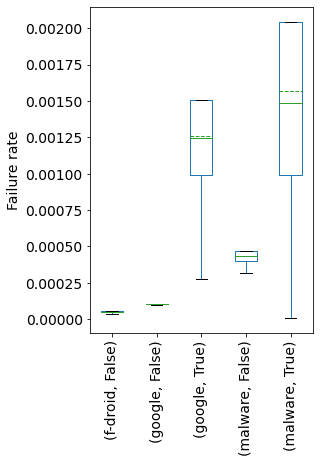

In [84]:
# Effect of packing.
samplings = [jadx_rate_df.sample(frac=1.0, replace=True).groupby(['Dataset','Packed'])['JadxRate'].mean() for i in range(1000)]
ax = pd.DataFrame(samplings).plot.box(whis=[0.025, 0.975], showfliers=False, showmeans=True, meanline=True, figsize=(4, 6))
ax.set_ylabel('Failure rate')
ax.tick_params(axis='x', labelrotation=90)
jadx_rate_df.groupby(['Dataset','Packed'])['JadxRate'].mean()*100

Ads
False    0.008613
True     0.013495
Name: JadxRate, dtype: float64

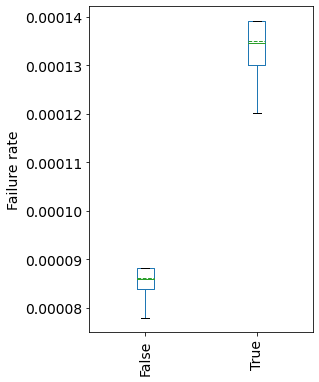

In [85]:
# Difference between Google Play apps with and without ads
google_df = jadx_rate_df[jadx_rate_df.Dataset == 'google']
samplings = [google_df.sample(frac=1.0, replace=True).groupby('Ads')['JadxRate'].mean() for i in range(1000)]
ax = pd.DataFrame(samplings).plot.box(whis=[0.025, 0.975], showfliers=False, showmeans=True, meanline=True, figsize=(4, 6))
ax.set_ylabel('Failure rate')
ax.tick_params(axis='x', labelrotation=90)
google_df.groupby('Ads')['JadxRate'].mean() * 100

In [30]:
# Load histogram of jadx failure distribution across different method sizes
jadx_bins_df = pd.read_parquet('jadx_bins_df.parquet')

# Load histogram of method size distribution
method_bins_df = pd.read_parquet('method_bins_df.parquet')

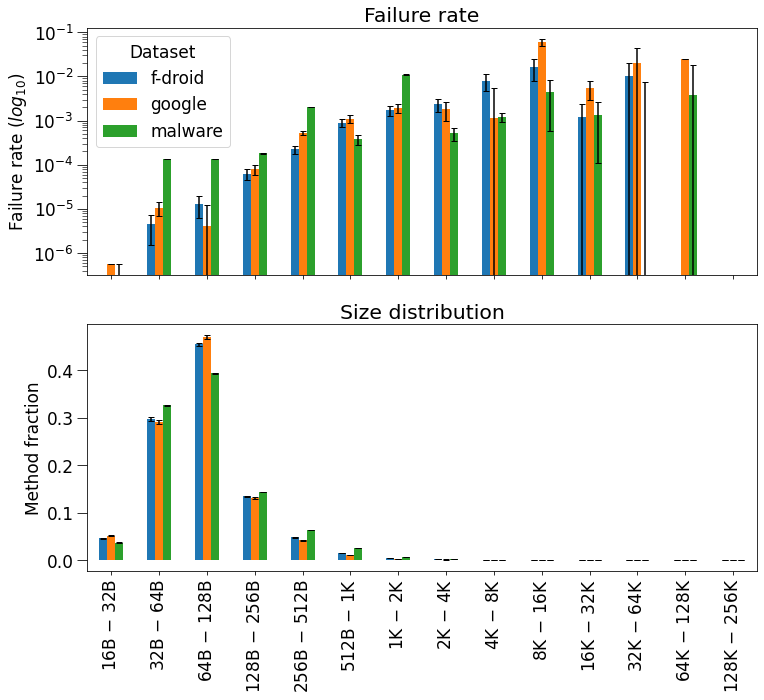

In [31]:
# Relationship between method size and decompilation failures in f-droid
from matplotlib import pyplot as plt

bin_ratios_df = jadx_bins_df/method_bins_df
bin_ratios_df = raw_main_df[['Dataset']].join(bin_ratios_df)
samples = [bin_ratios_df.sample(frac=1.0, replace=True).groupby('Dataset').mean() for i in range(1000)]
means = bin_ratios_df.groupby('Dataset').mean()
errors = np.abs(pd.concat(samples).groupby('Dataset').quantile([0.025, 0.975]) - means).to_numpy()

def shorten_sz(n):
    if n < 1024: 
        return "{}B".format(n)
    else: 
        return "{:.0f}K".format(n/1024)

plt.rc('font', size=17) 
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(12,10)

ax = means.T.plot.bar(ax=axes[0], yerr=errors, capsize=3)
ax.set_yscale('log')
ax.set_ylabel('Failure rate ($log_{10}$)')
ax.set_title('Failure rate')
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='y', which='minor', length=5)

method_dist_df = method_bins_df.div(method_bins_df.sum(axis=1), axis=0)
method_dist_df = raw_main_df[['Dataset']].join(method_dist_df)
samples = [method_dist_df.sample(frac=1.0, replace=True).groupby('Dataset').mean() for i in range(1000)]
means = method_dist_df.groupby('Dataset').mean()
errors = np.abs(pd.concat(samples).groupby('Dataset').quantile([0.025, 0.975]) - means).to_numpy()

ax = means.T.plot.bar(ax=axes[1], yerr=errors, capsize=3)
ax.set_ylabel('Method fraction')
ax.set_title('Size distribution')
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='y', which='minor', length=5)
ax.get_legend().remove()

bin_sizes = [int(i) for i in jadx_bins_df.columns]
labels = ["{} $-$ {}".format(shorten_sz(2**i),shorten_sz(2**(i+1))) for i in bin_sizes]
_ = plt.xticks(range(len(labels)), labels)

plt.savefig("latex/figures/size_bins.pdf", bbox_inches='tight')

In [117]:
# Load token frequency data
import lzma
import pickle

with lzma.open('token_frequencies.pickle.lzma', 'rb') as f:
    token_method_freq, token_fail_freq, token_app_freq = pickle.load(f)

In [119]:
# Create table with tokens associated with failures

import pylatex
from pylatex.utils import escape_latex

N_SHOWN=20
DATASETS=['f-droid', 'google', 'malware']

sorted_tokens = {}

for dataset in token_fail_freq:
    token_fail_norm = {k: token_fail_freq[dataset][k] for k,v in token_method_freq[dataset].items() if token_fail_freq[dataset][k]/v > 0.01}
    sorted_tokens[dataset] = [(escape_latex(items[0]), items[1], 100*items[1]/token_method_freq[dataset][items[0]]) for items in sorted(token_fail_norm.items(), key=lambda item: item[1], reverse=True)]

print('\\begin{tabular}{' + '|lrr' * len(DATASETS) + '|}')
print('\\hline')
print(' & '.join(['\multicolumn{{3}}{{|c|}}{{{0}}}'.format(ds) for ds in DATASETS]) + ' \\\\')
print(' & '.join(['Token & Failures & Frequency']*len(DATASETS)) + ' \\\\')
print('\\hline')
for i in range(N_SHOWN):
    print(' & '.join(['{} & {} & {:.2f}\%'.format(*sorted_tokens[ds][i]) for ds in DATASETS]) + ' \\\\')
print('\\hline')
print('\\end{tabular}')    

\begin{tabular}{|lrr|lrr|lrr|}
\hline
\multicolumn{3}{|c|}{f-droid} & \multicolumn{3}{|c|}{google} & \multicolumn{3}{|c|}{malware} \\
Token & Failures & Frequency & Token & Failures & Frequency & Token & Failures & Frequency \\
\hline
SlidingWindowKt & 183 & 9.30\% & apptimize & 2595 & 1.72\% & BugSenseHandler & 2034 & 1.50\% \\
windowedIterator & 183 & 20.29\% & SlidingWindowKt & 1901 & 9.14\% & Encoder & 544 & 2.33\% \\
ReaderBasedJsonParser & 83 & 1.56\% & windowedIterator & 1863 & 19.49\% & ZLDTDParser & 438 & 50.00\% \\
NonBlockingJsonParser & 48 & 3.52\% & ReaderBasedJsonParser & 1390 & 1.60\% & ReaderBasedParser & 426 & 3.30\% \\
MergerBiFunction & 37 & 27.41\% & NonBlockingJsonParser & 1112 & 3.48\% & jianmo & 283 & 1.07\% \\
ASN1Set & 28 & 1.48\% & BaseListBitmapDataSubscriber & 849 & 30.53\% & igexin & 251 & 1.24\% \\
ConstructedOctetStream & 28 & 12.17\% & zzdfh & 772 & 5.54\% & Utf8StreamParser & 216 & 1.02\% \\
ConverterSet & 28 & 6.22\% & MergerBiFunction & 664 & 22.13\% 